# Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.metrics import classification_report, confusion_matrix


from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, Activation, BatchNormalization
from keras.applications import densenet

from google.colab import files
from tensorflow.keras.preprocessing import image

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix

# Define Path

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
BASE_DIR = "//content/drive/MyDrive/Colab Notebooks/DL PROJECT/"
!ls "//content/drive/MyDrive/Colab Notebooks/DL PROJECT/"

'code v1.1.ipynb'   dataset   dataset-20231018T035451Z-001.zip	 model


In [5]:
DATASET_DIR = "/content/drive/MyDrive/Colab Notebooks/DL PROJECT/dataset/coffee_data/"
!ls "/content/drive/MyDrive/Colab Notebooks/DL PROJECT/dataset/coffee_data"

test  train  val


# Data Augmentation

In [6]:
test_datagen = ImageDataGenerator(rescale=1./255) # data test needs to be discaling
val_datagen = ImageDataGenerator(rescale=1./255) # data validation needs to be discaling

#  data train augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

In [7]:
image_size = (224, 224)  # expected image size
batch_size = 32  # number of images per batch
class_mode = 'categorical'  # Class mode for multi-class classification

# training data
train_generator = train_datagen.flow_from_directory(
    directory= DATASET_DIR + "train/",
    target_size=image_size,
    batch_size=batch_size,
    class_mode=class_mode,
)

# validation data
valid_generator = val_datagen.flow_from_directory(
    directory= DATASET_DIR + "val/",
    target_size=image_size,
    batch_size=batch_size,
    class_mode=class_mode,
)

# test data
test_generator = test_datagen.flow_from_directory(
    directory= DATASET_DIR + "test/",
    target_size=image_size,
    batch_size=batch_size,
    class_mode=class_mode,
    shuffle=False
)

Found 1200 images belonging to 4 classes.
Found 280 images belonging to 4 classes.
Found 120 images belonging to 4 classes.


## Image Augmentation Result

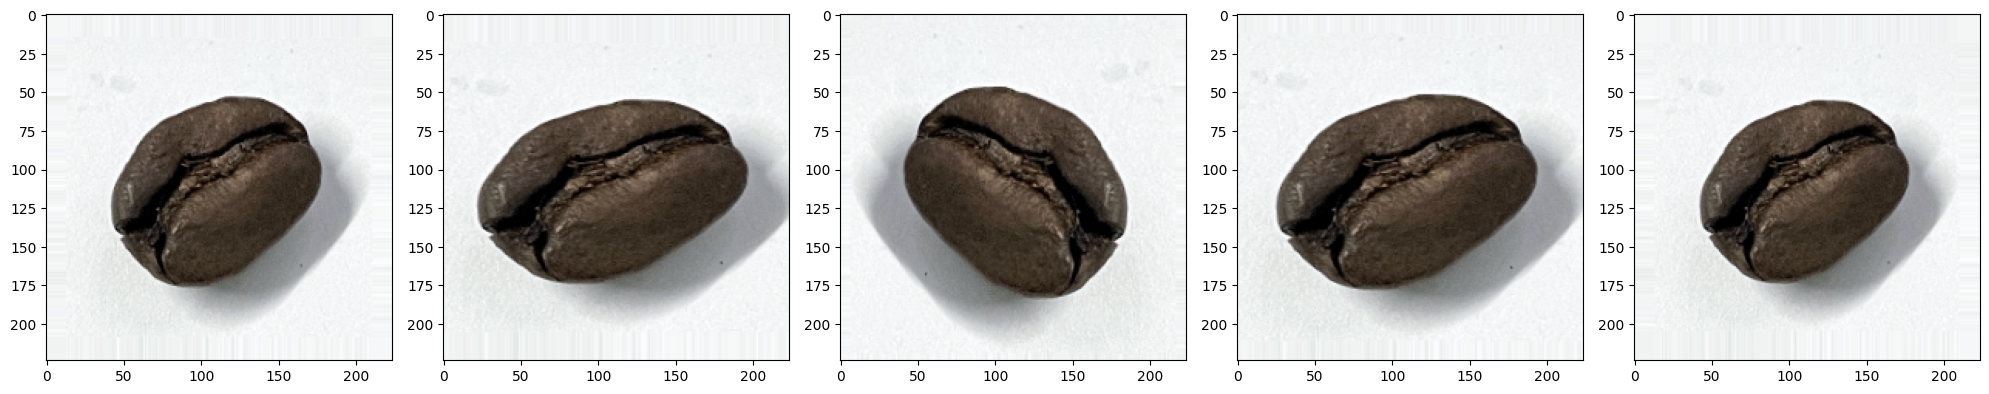

In [17]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()


augmented_images = [train_generator[0][0][0] for i in range(5)]
plotImages(augmented_images)

# Build Entire Model

## Setup Model ResNet50V2

In [18]:

base_model = tf.keras.applications.ResNet50V2(include_top= False,)

base_model.trainable = False

inputs = tf.keras.layers.Input(shape =(224,224,3), name = "input-layer")

x = tf.keras.layers.experimental.preprocessing.Rescaling(1/255.)(inputs)

x = base_model(inputs)
x = tf.keras.layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)
outputs = tf.keras.layers.Dense(4, activation = "softmax", name = "output-layer")(x)
model = tf.keras.Model(inputs, outputs)

print("SETUP MODEL SUCCESS!")

SETUP MODEL SUCCESS!


## Compile Model ResNet50V2

In [19]:



model.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
                metrics = ["accuracy"])


print("MODEL HAS BEEN COMPILED!")

MODEL HAS BEEN COMPILED!


In [20]:

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input-layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, None, None, 2048   23564800  
                             )                                   
                                                                 
 global_average_pooling_lay  (None, 2048)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output-layer (Dense)        (None, 4)                 8196      
                                                                 
Total params: 23572996 (89.92 MB)
Trainable params: 8196 (32.02 KB)
Non-trainable params: 23564800 (89.89 MB)
_______________

## Train Model ResNet50V2

In [21]:

history = model.fit(train_generator,
                    epochs=5,
                     steps_per_epoch = len(train_generator),
                     validation_data = valid_generator,
                     validation_steps = int(0.25*len(valid_generator))
                     )

Epoch 1/5
38/38 [==============================] - 26s 611ms/step - loss: 1.0964 - accuracy: 0.5842 - val_loss: 0.3212 - val_accuracy: 0.8906
Epoch 2/5
38/38 [==============================] - 21s 551ms/step - loss: 0.3351 - accuracy: 0.9058 - val_loss: 0.1826 - val_accuracy: 0.9844
Epoch 3/5
38/38 [==============================] - 21s 561ms/step - loss: 0.2298 - accuracy: 0.9417 - val_loss: 0.2122 - val_accuracy: 0.9375
Epoch 4/5
38/38 [==============================] - 21s 539ms/step - loss: 0.1811 - accuracy: 0.9550 - val_loss: 0.1478 - val_accuracy: 0.9688
Epoch 5/5
38/38 [==============================] - 21s 552ms/step - loss: 0.1564 - accuracy: 0.9558 - val_loss: 0.1527 - val_accuracy: 0.9375


# Save Model

In [22]:
model.save("/content/drive/MyDrive/Colab Notebooks/DL PROJECT/model/resnetV2_coffee.h5")
resnetV2_coffee = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/DL PROJECT/model/resnetV2_coffee.h5")

# Evaluate the Model

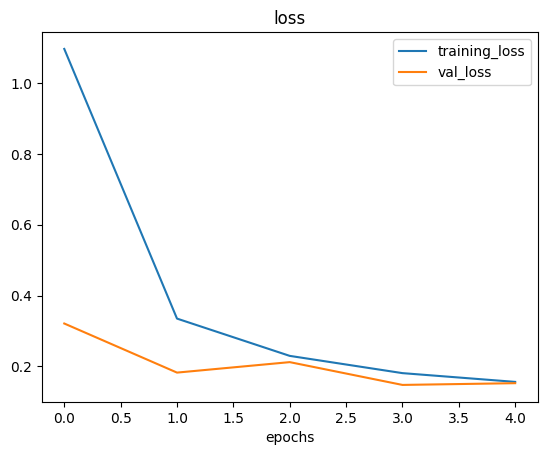

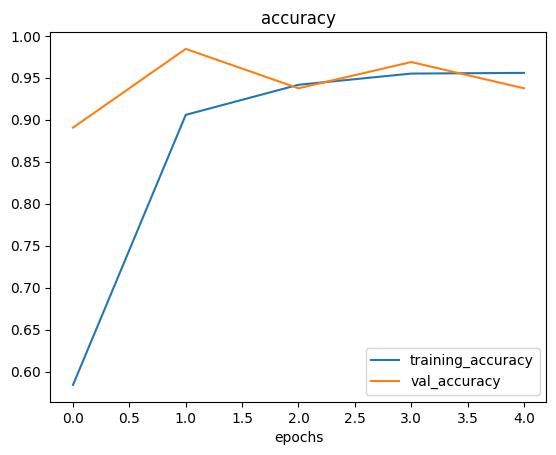

In [23]:
def plot_loss_curves(history):

  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  #plot loss
  plt.plot(epochs, loss, label = "training_loss")
  plt.plot(epochs, val_loss, label = "val_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  #plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label = "training_accuracy")
  plt.plot(epochs, val_accuracy, label = "val_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()

plot_loss_curves(history)

# Calculate Accuracy with Test Data

In [24]:
# Calculating Accuracy - Test Data
loss, accuracy = resnetV2_coffee.evaluate(test_generator)

print("The test loss is: ", loss)
print("The best accuracy is: ", accuracy)

4/4 [==============================] - 77s 25s/step - loss: 0.1337 - accuracy: 0.9750
The test loss is:  0.133744478225708
The best accuracy is:  0.9750000238418579


In [25]:
Y_pred = resnetV2_coffee.predict(test_generator, len(test_generator))
y_pred = np.argmax(Y_pred, axis=1)

target_names = list(test_generator.class_indices.keys())

print(classification_report(test_generator.classes, y_pred, target_names=target_names))

4/4 [==============================] - 4s 402ms/step
              precision    recall  f1-score   support

        Dark       1.00      0.93      0.97        30
       Green       1.00      1.00      1.00        30
       Light       1.00      0.97      0.98        30
      Medium       0.91      1.00      0.95        30

    accuracy                           0.97       120
   macro avg       0.98      0.97      0.98       120
weighted avg       0.98      0.97      0.98       120



# Visualized Confusion Matrix

<Axes: >

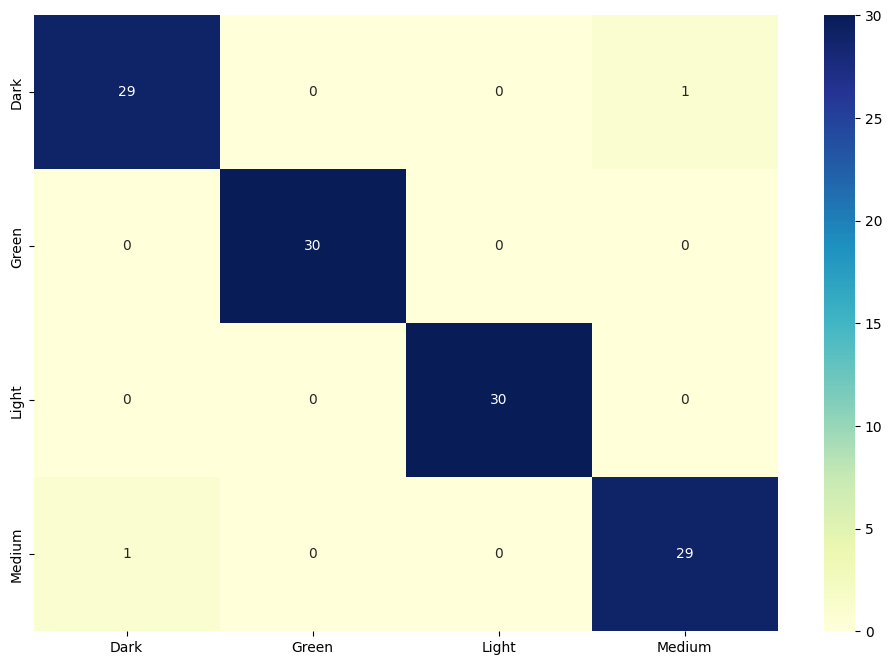

In [ ]:

import seaborn as sns

conf_mat = confusion_matrix(test_generator.classes, y_pred)
df_cm = pd.DataFrame(conf_mat, index = target_names, columns = target_names)
plt.figure(figsize = (12,8))
sns.heatmap(df_cm, annot=True,cmap="YlGnBu")

# Test the Data

Saving dark (31).png to dark (31).png
1/1 [==============================] - 1s 1s/step


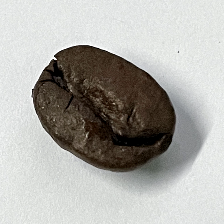

Prediction Result: Dark


In [26]:
class_names = ["Dark", "Green", "Light", "Medium"]

from google.colab import files

uploaded = files.upload()
for fn in uploaded.keys():
    path = fn
    img = image.load_img(path, target_size=(224,224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

predictions = resnetV2_coffee.predict(img_array)
predicted_class_index = np.argmax(predictions, axis=1)
predicted_class = class_names[predicted_class_index[0]]

display(img)

print("Prediction Result:", predicted_class)